# Phase 2 - Prediction

In [399]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Load data

In [409]:
features_df = pd.read_csv("prediction.csv").astype(int)
indicator_col = "DEPRESSIONINDEX"

### Create the OLS prediction model
The obtained model poorly predicts the target variable.

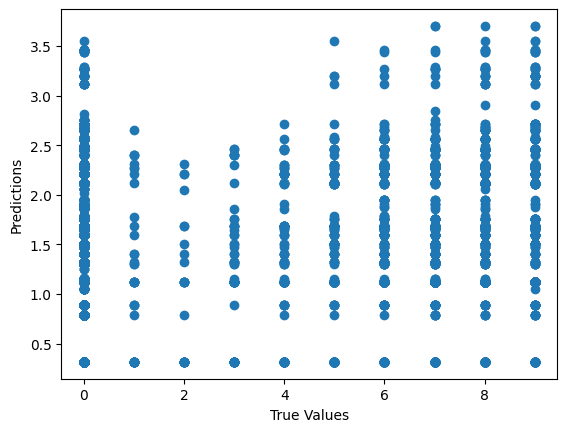

In [401]:
X = features_df.drop(columns=[indicator_col])
y = features_df[indicator_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

formula = f"{indicator_col} ~ " + " + ".join([f"C({col})" for col in X.columns])
data = pd.concat([X_train, y_train], axis=1)
model = smf.ols(formula=formula, data=data).fit()
model.summary()
y_pred = model.predict(X_test)

plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.scatter(y_test, y_pred)

### Apply sigmoid to obtain probabilities

In [402]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_pred_prob = sigmoid(y_pred)

risk_df = X_test.copy()
risk_df["PREDICTION"] = y_pred_prob
risk_df["ACTUAL"] = np.where(y_test > 0, 1, 0)
risk_df = risk_df.sort_values(by="PREDICTION", ascending=False)

### Split to N groups
After performing the split, there are N groups of data that have similar probabilities. This means that values of factors in each group are similar.

<Axes: xlabel='Risk Group', ylabel='Risk'>

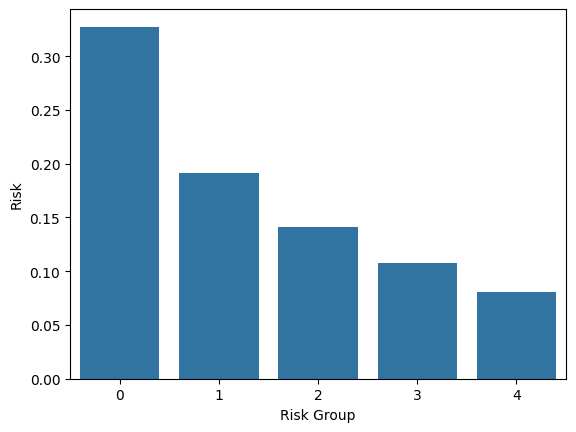

In [403]:
N_GROUPS = 5
risk_dfs = np.array_split(risk_df, N_GROUPS)

risk = []
for i, risk_df in enumerate(risk_dfs):
    risk_df["GROUP"] = i
    risk.append(risk_df["ACTUAL"].sum() / len(risk_df))

risk_df = pd.concat(risk_dfs)

plt.xlabel("Risk Group")
plt.ylabel("Risk")
sns.barplot(x=range(N_GROUPS), y=risk)

### Create the Random Forest Classifier
The Random Forest Classifier classifies given factors into one of the N groups.

<Axes: >

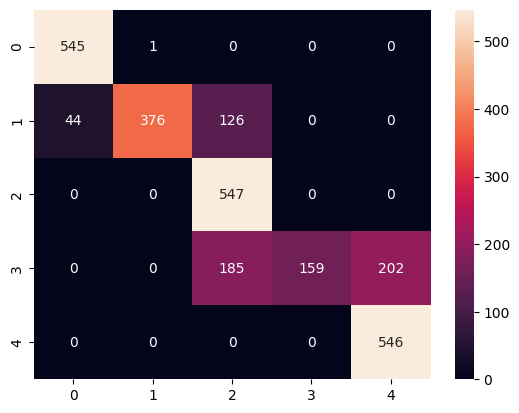

In [404]:
X = risk_df[X.columns]
y = risk_df["GROUP"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)

plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(confusion_matrix, annot=True, fmt="d")

### Lowest vs Highest risk groups
This analysis shows the difference in value of factors between the lowest and highest risk groups.

The low-risk can be identified as:
- little to no drug use
- man
- no assault

The high-risk can be identified as:
- use of one or more drugs
- woman
- assaulted someone

In [405]:
high_risk_df = risk_df[risk_df["GROUP"] == 0]
low_risk_df = risk_df[risk_df["GROUP"] == N_GROUPS-1]

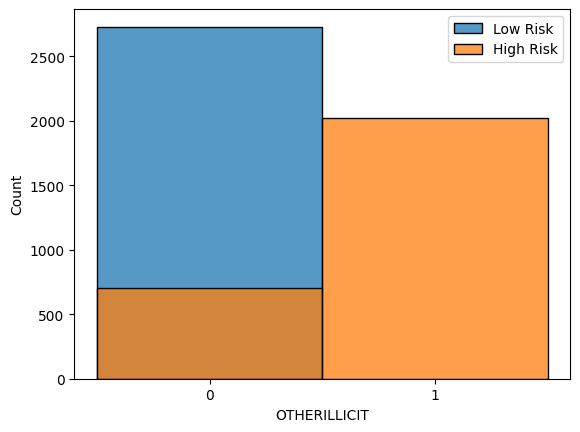

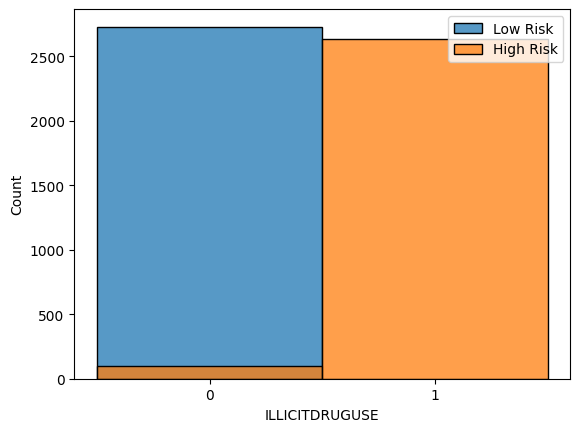

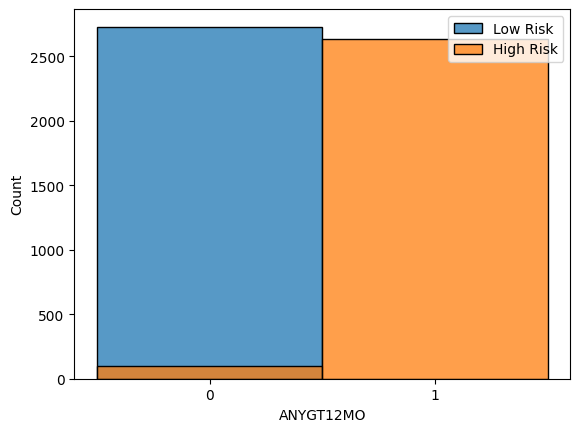

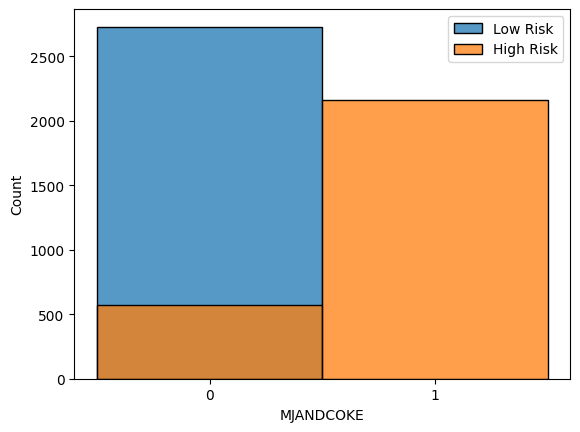

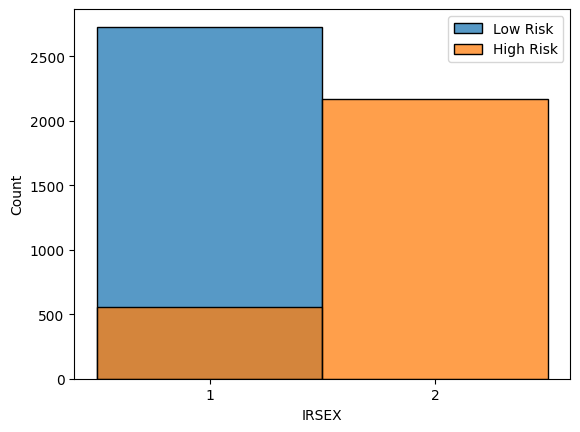

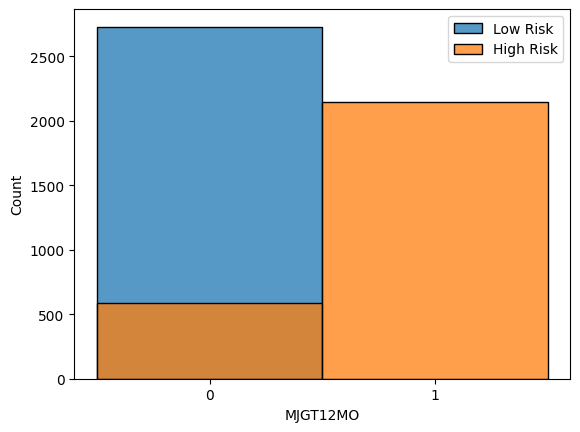

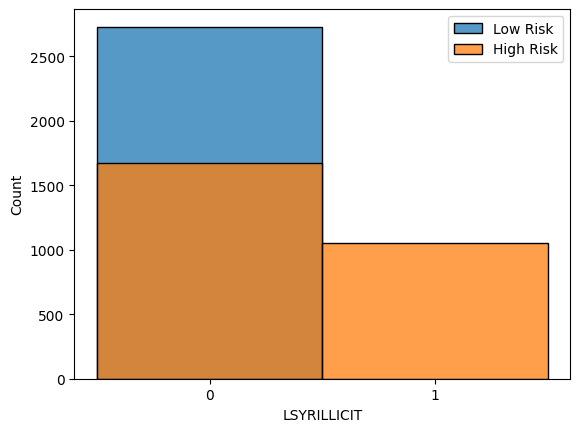

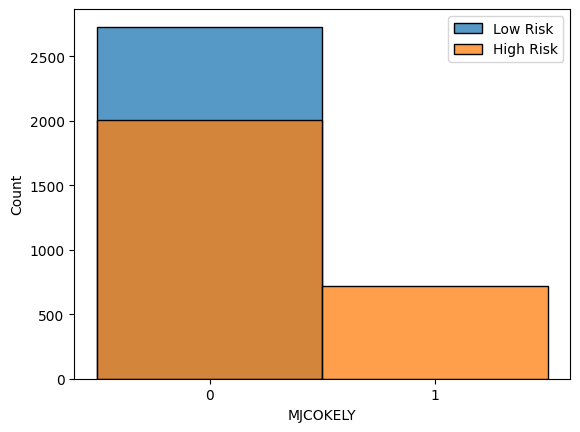

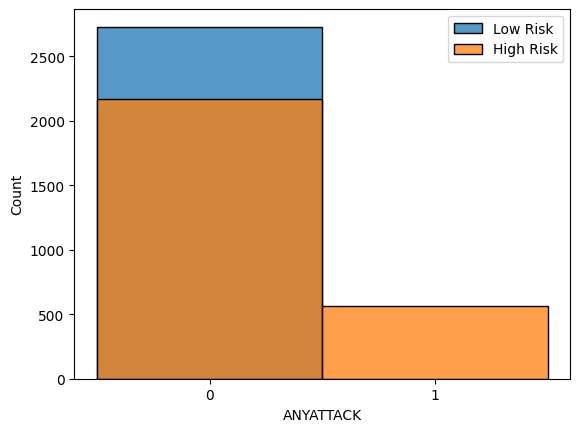

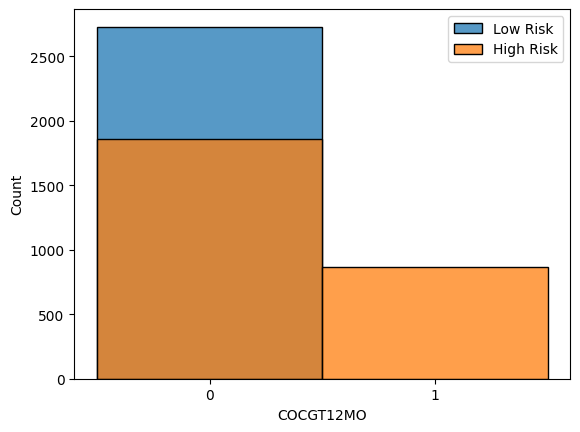

In [408]:
for col in X.columns:
    ax = sns.histplot(low_risk_df[col], label="Low Risk", discrete=True)
    sns.histplot(high_risk_df[col], label="High Risk", discrete=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.legend()
    plt.show()